In [1]:
# pylint: disable=not-callable
# pylint: disable=no-member

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import functions as F


def set_tensor(arr, device):
    return torch.from_numpy(arr).float().to(device)

In [2]:

class PredictiveCodingNetwork(object):
    def __init__(self, cf):
        self.device = cf.device
        self.n_layers = cf.n_layers
        self.act_fn = cf.act_fn
        self.neurons = cf.neurons
        self.vars = cf.vars.float().to(self.device)
        self.itr_max = cf.itr_max
        self.batch_size = cf.batch_size

        self.beta_1 = cf.beta_1
        self.beta_2 = cf.beta_2
        self.beta = cf.beta
        self.div = cf.div
        self.d_rate = cf.d_rate
        self.l_rate = cf.l_rate
        self.condition = cf.condition / (sum(cf.neurons) - cf.neurons[0])

        self.optim = cf.optim
        self.eps = cf.eps
        self.decay_r = cf.decay_r
        self.c_b = [[] for _ in range(self.n_layers)]
        self.c_w = [[] for _ in range(self.n_layers)]
        self.v_b = [[] for _ in range(self.n_layers)]
        self.v_w = [[] for _ in range(self.n_layers)]

        self.W = None
        self.b = None
        self._init_params()

    def train_epoch(self, x_batches, y_batches, epoch_num=None):
        n_batches = len(x_batches)
        for batch_id, (x_batch, y_batch) in enumerate(zip(x_batches, y_batches)):

            if batch_id % 500 == 0 and batch_id > 0:
                print(f"batch {batch_id}")

            x_batch = set_tensor(x_batch, self.device)
            y_batch = set_tensor(y_batch, self.device)
            batch_size = x_batch.size(1)   

            x = [[] for _ in range(self.n_layers)]
            x[0] = x_batch
            for l in range(1, self.n_layers):
                b = self.b[l - 1].repeat(1, batch_size)
                x[l] = self.W[l - 1] @ F.f(x[l - 1], self.act_fn) + b   
            x[self.n_layers - 1] = y_batch

            x, errors, _ = self.infer(x, batch_size)
            self.update_params(
                x, errors, batch_size, epoch_num=epoch_num, n_batches=n_batches, curr_batch=batch_id
            )

            if batch_id == 1:
                plot_imgs(x_batch, "D:/Documents/documents/LectureMaterial/2022_1/BIM/ProjectC/Term C_2022_distribution/plot_imgs"+str(epoch_num)+".png")


    def test_epoch(self, x_batches, y_batches):
        accs = []
        for x_batch, y_batch in zip(x_batches, y_batches):
            x_batch = set_tensor(x_batch, self.device)
            y_batch = set_tensor(y_batch, self.device)
            batch_size = x_batch.size(1)

            x = [[] for _ in range(self.n_layers)]
            x[0] = x_batch
            for l in range(1, self.n_layers):
                b = self.b[l - 1].repeat(1, batch_size)
                x[l] = self.W[l - 1] @ F.f(x[l - 1], self.act_fn) + b
            pred_y = x[-1]

            acc = mnist_accuracy(pred_y, y_batch)
            accs.append(acc)
        return accs

    def generate_data(self, x_batch):
        x_batch = set_tensor(x_batch, self.device)
        batch_size = x_batch.size(1)

        x = [[] for _ in range(self.n_layers)]
        x[0] = x_batch
        for l in range(1, self.n_layers):
            b = self.b[l - 1].repeat(1, batch_size)
            x[l] = self.W[l - 1] @ F.f(x[l - 1], self.act_fn) + b
        pred_y = x[-1]
        return pred_y

    def infer(self, x, batch_size):
        mu = [[] for _ in range(self.n_layers)]
        errors = [[] for _ in range(self.n_layers)]
        f_x_arr = [[] for _ in range(self.n_layers)]
        f_x_deriv_arr = [[] for _ in range(self.n_layers)]
        f_0 = 0
        its = 0
        beta = self.beta  # 0.1

        for l in range(1, self.n_layers):
            f_x = F.f(x[l - 1], self.act_fn)
            f_x_deriv = F.f_deriv(x[l - 1], self.act_fn)
            f_x_arr[l - 1] = f_x
            f_x_deriv_arr[l - 1] = f_x_deriv

            b = self.b[l - 1].repeat(1, batch_size)
            mu[l] = self.W[l - 1] @ F.f(x[l - 1], self.act_fn) + b
            errors[l] = (x[l] - mu[l]) / self.vars[l]
            f_0 = f_0 + (-0.5) * sum(((x[l] - b)**2)/self.vars[l])

        for itr in range(self.itr_max):  # 0~49
            # update node activity
            for l in range(1, self.n_layers - 1): # 1,2

                x[l] = errors[l] + self.W[l-1]@f_x_arr[l-1] 

            # update errors
            f = 0
            for l in range(1, self.n_layers):
                f_x = F.f(x[l - 1], self.act_fn)
                f_x_deriv = F.f_deriv(x[l - 1], self.act_fn)
                f_x_arr[l - 1] = f_x
                f_x_deriv_arr[l - 1] = f_x_deriv
                b = self.b[l - 1].repeat(1, batch_size) 
                mu[l] = self.W[l - 1] @ F.f(x[l - 1], self.act_fn) + b
                errors[l] = (x[l] - mu[l]) / self.vars[l]
                f = f + (-0.5) * sum(((x[l] - b)**2)/self.vars[l])

            diff = f - f_0
            threshold = self.condition * self.beta / self.vars[self.n_layers - 1] 
            if torch.any(diff < 0):
                beta = beta / self.div
            elif torch.mean(diff) < threshold:
                break

            f_0 = f
            its = itr

        return x, errors, its

    def update_params(self, x, errors, batch_size, epoch_num=None, n_batches=None, curr_batch=None):
        grad_w = [[] for _ in range(self.n_layers - 1)]
        grad_b = [[] for _ in range(self.n_layers - 1)]

        for l in range(self.n_layers - 1):
            grad_w[l] = errors[l+1] @ torch.transpose(F.f(x[l], self.act_fn), 0, 1)
            grad_b[l] = self.vars[-1] * (1 / batch_size) * torch.sum(errors[l + 1], axis=1)

        self._apply_gradients(grad_w, grad_b, epoch_num=epoch_num, n_batches=n_batches, curr_batch=curr_batch)

    def _init_params(self):
        weights = [[] for _ in range(self.n_layers)]
        bias = [[] for _ in range(self.n_layers)]

        for l in range(self.n_layers - 1):
            norm_b = 0
            if self.act_fn is F.LINEAR:
                norm_w = np.sqrt(1 / (self.neurons[l + 1] + self.neurons[l]))
            elif self.act_fn is F.TANH:
                norm_w = np.sqrt(6 / (self.neurons[l + 1] + self.neurons[l]))
            elif self.act_fn is F.LOGSIG:
                norm_w = 4 * np.sqrt(6 / (self.neurons[l + 1] + self.neurons[l]))
            else:
                raise ValueError(f"{self.act_fn} not supported")

            layer_w = np.random.uniform(-1, 1, size=(self.neurons[l + 1], self.neurons[l])) * norm_w
            layer_b = np.zeros((self.neurons[l + 1], 1)) + norm_b * np.ones((self.neurons[l + 1], 1))
            weights[l] = set_tensor(layer_w, self.device)
            bias[l] = set_tensor(layer_b, self.device)

        self.W = weights
        self.b = bias

        for l in range(self.n_layers - 1):
            self.c_b[l] = torch.zeros_like(self.b[l])
            self.c_w[l] = torch.zeros_like(self.W[l])
            self.v_b[l] = torch.zeros_like(self.b[l])
            self.v_w[l] = torch.zeros_like(self.W[l])

    def _apply_gradients(self, grad_w, grad_b, epoch_num=None, n_batches=None, curr_batch=None):

        if self.optim is "RMSPROP":
            for l in range(self.n_layers - 1):
                grad_b[l] = grad_b[l].unsqueeze(dim=1)
                self.c_w[l] = self.decay_r * self.c_w[l] + (1 - self.decay_r) * grad_w[l] ** 2
                self.c_b[l] = self.decay_r * self.c_b[l] + (1 - self.decay_r) * grad_b[l] ** 2

                self.W[l] = self.W[l] + self.l_rate * (grad_w[l] / (torch.sqrt(self.c_w[l]) + self.eps))
                self.b[l] = self.b[l] + self.l_rate * (grad_b[l] / (torch.sqrt(self.c_b[l]) + self.eps))

        elif self.optim is "ADAM":
            for l in range(self.n_layers - 1):
                grad_b[l] = grad_b[l].unsqueeze(dim=1)
                self.c_b[l] = self.beta_1 * self.c_b[l] + (1 - self.beta_1) * grad_b[l]
                self.c_w[l] = self.beta_1 * self.c_w[l] + (1 - self.beta_1) * grad_w[l]

                self.v_b[l] = self.beta_2 * self.v_b[l] + (1 - self.beta_2) * grad_b[l] ** 2
                self.v_w[l] = self.beta_2 * self.v_w[l] + (1 - self.beta_2) * grad_w[l] ** 2

                t = (epoch_num) * n_batches + curr_batch
                self.W[l] = self.W[l] + self.l_rate * np.sqrt(1 - self.beta_2 ** t) * self.c_w[l] / (
                    torch.sqrt(self.v_w[l]) + self.eps
                )
                self.b[l] = self.b[l] + self.l_rate * np.sqrt(1 - self.beta_2 ** t) * self.c_b[l] / (
                    torch.sqrt(self.v_b[l]) + self.eps
                )

        elif self.optim is "SGD" or self.optim is None:
            for l in range(self.n_layers - 1):
                self.W[l] = self.W[l] + self.l_rate * grad_w[l]
                self.b[l] = self.b[l] + self.l_rate * grad_b[l].unsqueeze(dim=1)

        else:
            raise ValueError(f"{self.optim} not supported")

In [3]:

def get_mnist_train_set():
    #return torchvision.datasets.MNIST("MNIST_train", download=True, train=True)
    return torchvision.datasets.MNIST("MNIST_train", download=True, train=True)


def get_mnist_test_set():
    return torchvision.datasets.MNIST("MNIST_test", download=True, train=False)


def onehot(label, n_classes=10):
    arr = np.zeros([10])
    arr[int(label)] = 1.0
    return arr


def img_to_np(img):
    return np.array(img).reshape([784]) / 255.0


def get_imgs(dataset):
    imgs = np.array([img_to_np(dataset[i][0]) for i in range(len(dataset))])
    return np.swapaxes(imgs, 0, 1)


def get_labels(dataset):
    labels = np.array([onehot(dataset[i][1]) for i in range(len(dataset))])
    return np.swapaxes(labels, 0, 1)


def scale_imgs(imgs, scale_factor):
    return imgs * scale_factor + 0.5 * (1 - scale_factor) * np.ones(imgs.shape)


def scale_labels(labels, scale_factor):
    return labels * scale_factor + 0.5 * (1 - scale_factor) * np.ones(labels.shape)


def mnist_accuracy(pred_labels, labels):
    correct = 0
    batch_size = pred_labels.size(1)
    for b in range(batch_size):
        if torch.argmax(pred_labels[:, b]) == torch.argmax(labels[:, b]):
            correct += 1
    return correct / batch_size


def get_batches(imgs, labels, batch_size):
    n_data = imgs.shape[1]   # 60000
    n_batches = int(np.ceil(n_data / batch_size))

    img_batches = [[] for _ in range(n_batches)]
    label_batches = [[] for _ in range(n_batches)]

    for batch in range(n_batches):
        if batch == n_batches - 1:
            start = batch * batch_size
            img_batches[batch] = imgs[:, start:]
            label_batches[batch] = labels[:, start:]
        else:
            start = batch * batch_size
            end = (batch + 1) * batch_size
            img_batches[batch] = imgs[:, start:end]
            label_batches[batch] = labels[:, start:end]

    return img_batches, label_batches


def plot_imgs(img_batch, save_path):
    img_batch = img_batch.detach().cpu().numpy()
    batch_size = img_batch.shape[1]
    dim = nearest_square(batch_size) # 15

    imgs = [np.reshape(img_batch[:, i], [28, 28]) for i in range(dim ** 2)]  #784 array to 28 x 28 image
    _, axes = plt.subplots(dim, dim)
    axes = axes.flatten()
    for i, img in enumerate(imgs):
        axes[i].imshow(img)
        axes[i].set_axis_off()
    plt.savefig(save_path)
    plt.close('all')


def nearest_square(limit):
    answer = 0
    while (answer + 1) ** 2 < limit:
        answer += 1
    return answer

class AttrDict(dict):
    __setattr__ = dict.__setitem__
    __getattr__ = dict.__getitem__


def main(cf):
    print(f"device [{cf.device}]")
    print("loading MNIST data...")
    train_set = get_mnist_train_set()
    test_set = get_mnist_test_set()

    img_train = get_imgs(train_set)
    img_test = get_imgs(test_set)
    label_train = get_labels(train_set)
    label_test = get_labels(test_set)

    if cf.data_size is not None:
        test_size = cf.data_size // 5
        img_train = img_train[:, 0 : cf.data_size]
        label_train = label_train[:, 0 : cf.data_size]
        img_test = img_test[:, 0:test_size]
        label_test = label_test[:, 0:test_size]

    msg = "img_train {} img_test {} label_train {} label_test {}"
    print(msg.format(img_train.shape, img_test.shape, label_train.shape, label_test.shape))

    print("performing preprocessing...")
    if cf.apply_scaling:
        img_train = scale_imgs(img_train, cf.img_scale)
        img_test = scale_imgs(img_test, cf.img_scale)
        label_train = scale_labels(label_train, cf.label_scale)
        label_test = scale_labels(label_test, cf.label_scale)

    if cf.apply_inv:
        img_train = F.f_inv(img_train, cf.act_fn)
        img_test = F.f_inv(img_test, cf.act_fn)

    model = PredictiveCodingNetwork(cf)

    test_accuracy_epoch = []
    with torch.no_grad():
    
        for epoch in range(cf.n_epochs):
            print(f"\nepoch {epoch}")

            img_batches, label_batches = get_batches(img_train, label_train, cf.batch_size)
            print(f"training on {len(img_batches)} batches of size {cf.batch_size}")
            model.train_epoch(img_batches, label_batches, epoch_num=epoch)
            
            img_batches, label_batches = get_batches(img_test, label_test, cf.batch_size)
            print(f"testing on {len(img_batches)} batches of size {cf.batch_size}")
            accs = model.test_epoch(img_batches, label_batches)
            print(f"average accuracy {np.mean(np.array(accs))}")
            test_accuracy_epoch.append(np.mean(np.array(accs)))
            perm = np.random.permutation(img_train.shape[1])
            img_train = img_train[:, perm]
            label_train = label_train[:, perm]

    plt.plot(test_accuracy_epoch)
    plt.title('Accuracy')
    plt.xlabel('Epoch')


device [cuda]
loading MNIST data...
img_train (784, 60000) img_test (784, 10000) label_train (10, 60000) label_test (10, 10000)
performing preprocessing...

epoch 0
training on 300 batches of size 200
testing on 50 batches of size 200
average accuracy 0.8240000000000001

epoch 1
training on 300 batches of size 200
testing on 50 batches of size 200
average accuracy 0.8553999999999999

epoch 2
training on 300 batches of size 200
testing on 50 batches of size 200
average accuracy 0.8709

epoch 3
training on 300 batches of size 200
testing on 50 batches of size 200
average accuracy 0.8700999999999999

epoch 4
training on 300 batches of size 200
testing on 50 batches of size 200
average accuracy 0.8781

epoch 5
training on 300 batches of size 200
testing on 50 batches of size 200
average accuracy 0.8766000000000002

epoch 6
training on 300 batches of size 200
testing on 50 batches of size 200
average accuracy 0.8783000000000001

epoch 7
training on 300 batches of size 200
testing on 50 batc

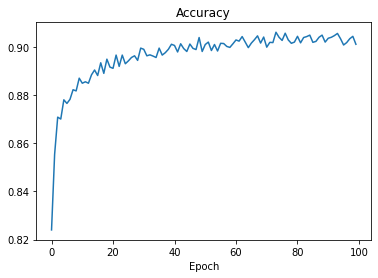

In [4]:

if __name__ == "__main__":
    cf = AttrDict()

    cf.n_epochs = 100
    cf.data_size = None
    cf.batch_size = 200   # 128 -> 200

    cf.apply_inv = True
    cf.apply_scaling = True
    cf.label_scale = 0.94
    cf.img_scale = 1.0

    cf.neurons = [784, 500, 500, 10]
    cf.n_layers = len(cf.neurons)
    cf.act_fn = F.TANH
    cf.var_out = 1
    cf.vars = torch.ones(cf.n_layers)

    cf.itr_max = 50
    cf.beta = 0.1
    cf.div = 2
    cf.condition = 1e-6
    cf.d_rate = 0

    # optim parameters
    cf.l_rate = 1e-3      
    cf.optim = "ADAM"
    cf.eps = 1e-8
    cf.decay_r = 0.9
    cf.beta_1 = 0.9
    cf.beta_2 = 0.999

    cf.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    main(cf)